In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

import pymc as pm
import pytensor as pt
from pymc import PolyaGamma as PG
from pymc import Normal as N

In [11]:
# TODO: try negating the true_b vector and use +b everywhere in calculations

def _compute_mean_a(v, b, theta, w, y):
    S = torch.sum(torch.mul(theta, y-0.5+torch.mul(b, w)))
    mean = v*S        
    return mean.item()

def _compute_var_a(sigmasq, theta, w):
    S = torch.sum(torch.mul(w, torch.pow(theta, 2))) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_b(v, a, theta, w, y):
    S = torch.sum(y-0.5-a*torch.mul(theta, w))
    mean = v*S
    return mean.item()

def _compute_var_b(sigmasq, w):
    S = torch.sum(w) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_t(v, a, b, w, y):
    S = torch.sum(torch.mul(a, y-0.5+torch.mul(b, w)))  
    mean = v*S
    return mean.item()    

def _compute_var_t(sigmasq, a, w):
    S = torch.sum(torch.mul(w, torch.pow(a, 2))) + 1/sigmasq
    #print("S ", S)
    #print(torch.mul(w, torch.pow(a, 2)))
    var = 1/S
    return var.item()

def polyagamma(init_a, init_b, init_t, init_w, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):

    assert init_a.shape == init_b.shape
    assert init_t.shape[0] == y.shape[0]
    assert y.shape == init_w.shape
    
    I = len(init_a)
    P = len(init_t)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))
    W = torch.empty(size=(niter, P, I))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_t
    W[0] = init_w

    print(f"Starting Gibbs sampler for Polya-Gamma... \n--------------------------------------------\n")
    for s in trange(niter):

        # sample Ws
        for p in range(P):
            for i in range(I):
                # TODO: vectorize? nested loop seems very slow
                W[s][p][i] = torch.from_numpy(pm.draw(PG.dist(h=1, z=(A[s-1][i]*THETA[s-1][p] + B[s-1][i]))))  # trying +b

        # sample As
        for i in range(I):
            var_a = _compute_var_a(sigmasq_a, THETA[s-1], W[s][:,i])
            mean_a = _compute_mean_a(var_a, B[s-1][i], THETA[s-1], W[s][:,i], y[:,i])
            #print(var_a)
            #print(mean_a)
            try:
                A[s][i] = torch.distributions.Normal(mean_a, var_a).sample()
            except ValueError:
                A[s][i] = torch.distributions.Normal(mean_a, var_a+0.001).sample()

        # sample Bs
        for i in range(I):
            var_b = _compute_var_b(sigmasq_b, W[s][:,i])
            mean_b = _compute_mean_b(var_b, A[s][i], THETA[s-1], W[s][:,i], y[:,i])
            try: 
                B[s][i] = torch.distributions.Normal(mean_b, var_b).sample()
            except ValueError:
                B[s][i] = torch.distributions.Normal(mean_b, var_b+0.001).sample()

        # sample THETAs
        for p in range(P):
            var_t = _compute_var_t(sigmasq_t, W[s][p], A[s])
            mean_t = _compute_mean_t(var_t, A[s], B[s], W[s][p,:], y[p,:])
            #print("mean: ", mean_t)
            #print("variance: ", var_t)
            try:
                THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()
            except ValueError:
                var_t = torch.abs(torch.tensor([var_t + 0.001]))
                THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()

    return A, B, THETA, W

In [13]:
# TEST

N = 1000  # iterations
I = 10     # exam items
P = 100    # pupils
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)
init_W = torch.zeros(P, I)

true_a = torch.tensor([1, 0.9, 0.01, 0.5, 0.7, 0.4, 0.03, 0.9, 0.8, 1])  # items' discriminatory power
true_b = -1.0*torch.tensor([0.01, 0.9, 1, 0.8, 0.2, 0.3, 0.88, 1, 0.3, 0.5])  # items' difficulty
true_theta = torch.empty(size=(P,)) #torch.tensor([1, 1, 0, 0.5, 0.7, 0.1, 0.3, 0.9, 0.6, 0.7])  # students' skills
true_W = torch.empty(size=(P,I))

# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# populate W:
for p in range(P):
    for i in range(I): 
        scale = true_a[i]*true_theta[p] + true_b[i]   # trying +b
        true_W[p][i] = torch.from_numpy(pm.draw(PG.dist(h=1, z=scale)))
        
# exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    #print(i)
    for p in range(P):
        #print(p)
        prob = torch.exp(true_a[i]*true_theta[p] + true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] + true_b[i])) # trying +b
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [0., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 0., 1., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 0., 1., 0., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 0., 1., 1., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],


In [14]:
# test with abs() wrapping var terms...not sure how it'll look
samples = polyagamma(init_a, init_b, init_t, init_W, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler for Polya-Gamma... 
--------------------------------------------



100%|██████████| 1000/1000 [1:44:07<00:00,  6.25s/it]


In [17]:
print("A:")
print(torch.mean(samples[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples[2], 0))  # mean over the columns
print(true_theta)

print("W:")
print(torch.mean(samples[3], 0))  # mean over the columns
print(true_W)

A:
tensor([-2.0775e-01,  1.9956e-01,  2.8911e+00,  5.8302e-01,  3.6622e-01,
         3.2391e-01,  5.5756e-01,  4.4323e-01, -3.6622e-04,  4.3923e-02])
tensor([1.0000, 0.9000, 0.0100, 0.5000, 0.7000, 0.4000, 0.0300, 0.9000, 0.8000,
        1.0000])
B:
tensor([ 2.3050e-01, -1.1471e-01,  2.9290e+02, -2.2503e-01, -1.7193e-01,
        -3.5650e-02, -1.9824e-01, -2.8769e-01,  7.2680e-02, -7.5762e-02])
tensor([-0.0100, -0.9000, -1.0000, -0.8000, -0.2000, -0.3000, -0.8800, -1.0000,
        -0.3000, -0.5000])
THETA:
tensor([-1.1828,  0.7586,  0.7059, -1.0302, -1.8207, -0.9000, -1.1383, -0.4939,
         1.1987,  0.8129,  0.7643, -1.3285, -1.7674, -1.5344,  0.8577,  0.9093,
         0.2675, -1.6059, -1.0833, -1.9138, -1.8473,  0.2392, -1.1264, -0.8969,
         0.2743, -1.0788, -1.7483, -1.8176,  0.5262, -1.5272, -1.1387, -1.3830,
        -1.8297, -1.3976, -1.7503, -2.2450, -2.0503,  0.1084, -1.1396, -1.2758,
        -1.8998,  0.4746,  0.4839, -1.8065, -1.0761, -1.7099, -0.7134,  0.4629,
        -

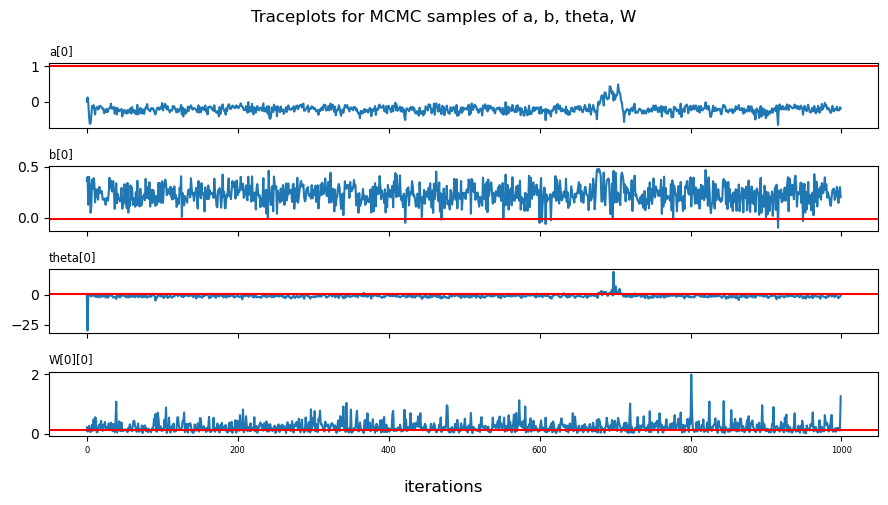

In [20]:
# Traceplots of samples
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5), sharex=True)
fig1.suptitle('Traceplots for MCMC samples of a, b, theta, W')

t = range(N)

ax1.plot(t, samples[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

ax4.plot(t, samples[3][:,0,0])
ax4.axhline(true_W[0][0], color="red")
ax4.set_title("W[0][0]", fontsize='small', loc='left')

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

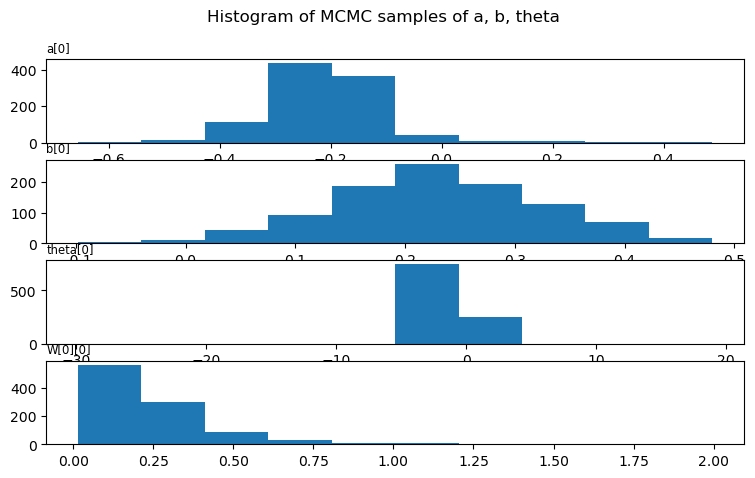

In [21]:
# Histogram of samples
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5))
fig2.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')
ax4.hist(samples[3][:,0,0])
ax4.set_title("W[0][0]", fontsize='small', loc='left')

plt.show()